# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle
import numpy as np

data_dir = "trafficSigns/data/"
training_file = data_dir + 'train.p'
testing_file = data_dir + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = x_train[0].shape
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


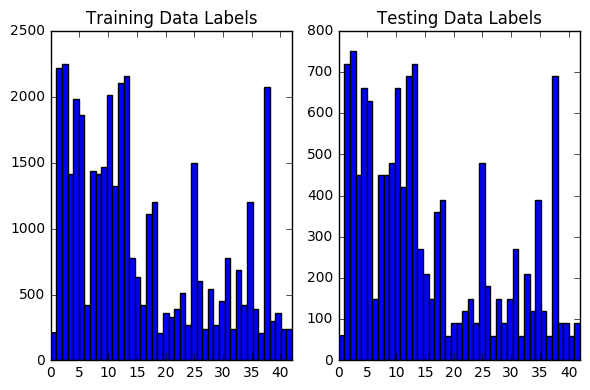

In [3]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

#visualize label distribution
plt.subplot(1,2,1).hist(y_train,43);
plt.xlim(0,42)
plt.title('Training Data Labels');
plt.subplot(1,2,2).hist(y_test,43);
plt.title('Testing Data Labels');
plt.xlim(0,42)
plt.tight_layout();

Images of some traffic signs are much more frequent that images of other signs. Testing and training data have very similar distibutions. 



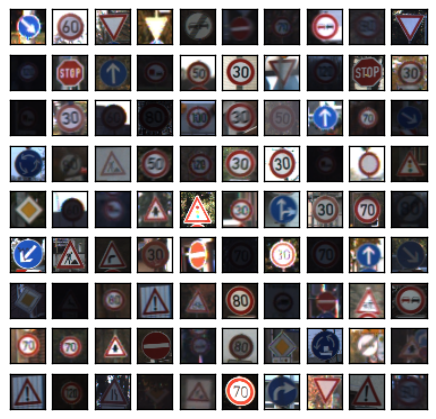

In [5]:
plt.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.1)

def get_random_images(images, how_many):
     rnd = random.sample(range(len(x_train)), how_many)
     return images[rnd]   

def plot_images(images, rows, cols):
    """Samples images randomly"""
    gs = gridspec.GridSpec(rows, cols, top=1.0, bottom=.0, right=.7, left=0., hspace=0.3,
                           wspace=0.1)

    for index, g in enumerate(gs):
        ax = plt.subplot(g)
        img = images[index]
        ax.imshow(img)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
plot_images(get_random_images(x_train, 90), 9, 10)    

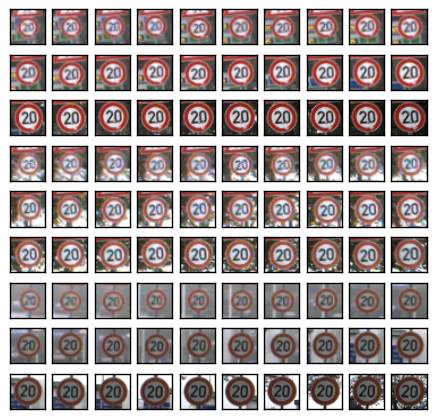

In [6]:
# let's also display some consecutive images
plot_images(x_train, 9,10)

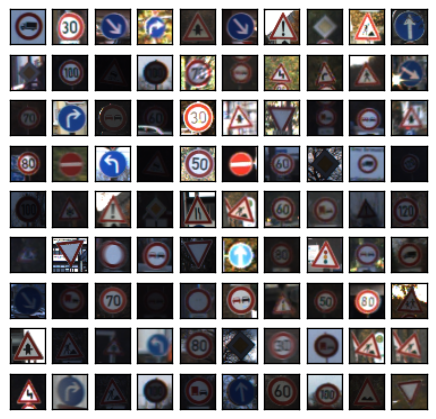

In [7]:
plot_images(x_test, 9,10)

The training dataset consist of batches of 30 images of the same sign, under same conditions taken from smaller and smaller distances. Also images for same sign are grouped together. Testing dataset does not have this problem.  

Becuase of the way training images are ordered it is important to shuffle the images during  training. Training without shuffling would result in using minibatches that consist of a very low number of images.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
def normalizeImages(images):
    images = images.astype('float32')
    images /= 255
    return images

def one_hot_encoding(original_labels, number_of_classes):
    encoded_labels = np.zeros((len(original_labels), number_of_classes))
    for i in range(len(original_labels)):
        encoded_labels[i, original_labels[i]] = 1.
    return encoded_labels

X_train = normalizeImages(x_train)
Y_train = one_hot_encoding(y_train,n_classes)

X_test = normalizeImages(x_test)
Y_test = one_hot_encoding(y_test,n_classes)

print("Training images:", X_train.shape, " labels:", Y_train.shape)
print("Testing images:", X_test.shape, " labels:", Y_test.shape)

Training images: (39209, 32, 32, 3)  labels: (39209, 43)
Testing images: (12630, 32, 32, 3)  labels: (12630, 43)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** I used pretty standard data preprocessing - normalized the images from 0-255 to 0-1 and used one hot encoding for labels.

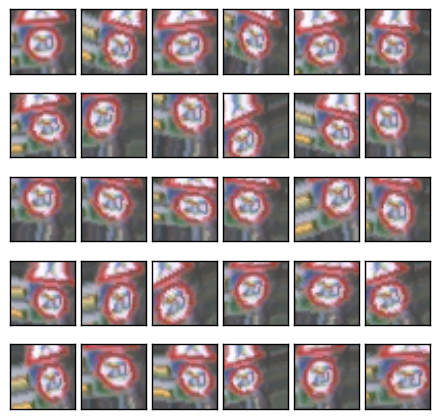

In [9]:
from trafficSigns.sdc import image_processing as ip

'''generator applies several transformations:
     - random rotation with angle between -10 and 10 degrees
     - random vertical and horizontal shift of up to 10% of image width and height respectively
     - 10% random zoom in and zoom out'''

datagen = ip.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2, 
    shear_range=0.2)

original_image = X_train[0]
new_images = np.array([original_image])

for i in range(29):
    new_images = np.append(new_images, [datagen.random_transform(original_image)], axis=0)
 

#the first image is the original image the rest of the images are generated
plot_images(new_images, 5,6)    

### Split training data into training and validation

In [10]:
def split_training_sets(images, labels):
    validationIndexes = int(labels.shape[0]/20)
    perm = np.arange(labels.shape[0])
    np.random.shuffle(perm)
    _images = images[perm]
    _labels = labels[perm]
    return _images[validationIndexes:], _labels[validationIndexes:],_images[:validationIndexes], _labels[:validationIndexes] 

X_train_split, Y_train_split, X_val, Y_val = split_training_sets(X_train, Y_train)


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** Original data is already split into training and testing datasets. 

I shuffled the original training data set and I assigned 10% of the images and labels to the validation dataset and the rest to training dataset. The testing dataset was the original testing dataset. I used the validation accuracy to select the best model and only after selecting the model I tested the accuracy on the test set. 

For this project doing proper hyper-parameter optimization would be very time consuming and impractical for me. Instead I experimented with several parameters using a small number of training epochs. I provide more details about the experiments I did in the answer to Question 5.
 
I considered at some point using data generation to generate images so all labels have roughly the same number of images. There are two reasons why I decided not to do this: first I wanted the labels distribution to reflect the reality and second I did not find papers that generated images for the less frequently seen labels.

It would not hurt to train the model with samples that have uniform label distribution but I guess I will try this some other time. 


### Network Architecture

In [12]:
import trafficSigns.sdc.layers as layers
import tensorflow as tf

def convolutional_net(x, n_classes, conv_dropout, hidden_dropout, show_info=True):
    # Convolution with Relu
    conv1 = layers.conv2d('conv1', x, 3, 32, show_info=show_info)
    layers.activation_summary(conv1)
    conv1 = layers.relu('conv1-relu',conv1, show_info=show_info)

    # Convolution with Relu and Max Pool
    conv2 = layers.conv2d('conv2', conv1, 3, 32, padding='VALID', show_info=show_info)
    layers.activation_summary(conv2)
    conv2 = layers.relu('conv2-relu',conv2,show_info=show_info)
    conv2 = layers.maxpool2d('conv2-maxpool',conv2, ksize=2,show_info=show_info)
    conv2 = layers.dropout_layer('conv2-dropout',conv2, conv_dropout,show_info=show_info)

    # Convolution with Relu
    conv3 = layers.conv2d('conv-3', conv2, 3, 64,show_info=show_info)
    layers.activation_summary(conv3)
    conv3 = layers.relu('conv3-relu',conv3,show_info=show_info)

    # Convolution with Relu and Max Pool
    conv4 = layers.conv2d('conv-4', conv3, 3, 64, padding='VALID',show_info=show_info)
    layers.activation_summary(conv4)
    conv4 = layers.relu('conv4-relu',conv4,show_info=show_info)
    conv4 = layers.maxpool2d('conv4-maxpool',conv4, ksize=2,show_info=show_info)
    conv4 = layers.dropout_layer('conv4-dropout',conv4, conv_dropout,show_info=show_info)

    # Reshape conv output to fit fully connected layer input
    fc1 = layers.flatten('flatten',conv4,show_info=show_info)

    # Fully connected hidden layer
    d1 = layers.dense('hidden', fc1, 512,show_info=show_info)
    layers.activation_summary(d1)
    d1 = layers.relu('hidden-relu',d1,show_info=show_info)
    d1 = layers.dropout_layer('hidden-dropout',d1, hidden_dropout,show_info=show_info)

    # Fully connected output layer
    out = layers.dense('output', d1, n_classes,show_info=show_info)
    layers.activation_summary(out)
    return out

tf.reset_default_graph()

#images
x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]])
#labels
y = tf.placeholder(tf.float32, [None, n_classes])
#dropout keep probabilibty in the convolution layer 
conv_prob = tf.placeholder(tf.float32)
#dropout keep probability in the hidden layer
hidden_prob = tf.placeholder(tf.float32)

logits = convolutional_net(x, n_classes, conv_prob, hidden_prob)

conv1                Shape: (?, 32, 32, 32)      Params:     896
conv1-relu           Shape: (?, 32, 32, 32)      Params:       0
conv2                Shape: (?, 30, 30, 32)      Params:    9248
conv2-relu           Shape: (?, 30, 30, 32)      Params:       0
conv2-maxpool        Shape: (?, 30, 30, 32)      Params:       0
conv2-dropout        Shape: (?, 15, 15, 32)      Params:       0
conv-3               Shape: (?, 15, 15, 64)      Params:   18496
conv3-relu           Shape: (?, 15, 15, 64)      Params:       0
conv-4               Shape: (?, 13, 13, 64)      Params:   36928
conv4-relu           Shape: (?, 13, 13, 64)      Params:       0
conv4-maxpool        Shape: (?, 13, 13, 64)      Params:       0
conv4-dropout        Shape: (?, 6, 6, 64)        Params:       0
flatten              Shape: (?, 2304)            Params:       0
hidden               Shape: (?, 512)             Params: 1180160
hidden-relu          Shape: (?, 512)             Params:       0
hidden-dropout       Shap

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The final architecture and the tensor output shape from each layer is shown above. Each layer shows the shape of the output tensor and the number of parameteres.

Other details:
 - The input is a tensor of images with shape (?, 32, 32, 3)
 - All convolution layers use a 3x3 filter
 - Convolution layers 1 and 2 have 32 filters while layers 3 and 4 have 64 filters
 - Convolution layers 1 and 3 use SAME padding and layers 2 and 4 use VALID padding
 - Convolution layers and the hidden layer use RELU activations. 
 - Convolution layers 2 and 4 use 2x2 max pooling. 
 - To prevent overfitting I am using dropout after convolution layers 2 and 4 and after the hidden layer.

### Training the Model

In [22]:
### Train your model here.
from trafficSigns.sdc import data_batching
from trafficSigns.sdc import model

learning_rate = 0.001
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#summaries used by Tensorboard. To open Tensorboard run 'tensorboard --logdir model_directory' 
summary_op = tf.merge_all_summaries()

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()
test_dataset = data_batching.DataSet(X_test, Y_test)
validation_dataset = data_batching.DataSet(X_val, Y_val)
train_dataset = data_batching.DataSet(X_train_split, Y_train_split)
#training was done on a 2013 MacBookPro with GPU enabled
#each epoch takes about 70 seconds for no immage proceesing during training.
#each epoch takes about 85 seconds when processing the images on the fly during training.
training_epochs = 30
#during training dropout is enabled to prevent overfitting
train_dict = {conv_prob: 0.75, hidden_prob: 0.5}
#turn off dropout during testing or evaluating the model
test_dict = {conv_prob: 1.0, hidden_prob: 1.0}
#directory where the model saves checkpoints and events used by tensorflow
#with the current setting the model is saved after each checkpoint and it keeps 5 most recent checkpoints
model_directory = "/tmp/traffic_signs"
md = model.Model(x, y,n_classes,train_dict, test_dict, model_directory)

with tf.Session() as sess:
    sess.run(init)
    md.train(sess, train_dataset, optimizer, cost, accuracy, summary_op,
                    training_epochs, batch_size=32, generate_image=True, checkpoint_step=10)
    md.evaluate(validation_dataset, logits, sess, type='Validation')
    md.evaluate(test_dataset, logits, sess, type='Testing')


Epoch 1/30, Batch   50/1165, Minibatch Loss= 3.461364, Training Accuracy= 0.06250, Total Training time = 4.79
Epoch 1/30, Batch  100/1165, Minibatch Loss= 3.292914, Training Accuracy= 0.06250, Total Training time = 8.15
Epoch 1/30, Batch  150/1165, Minibatch Loss= 3.156485, Training Accuracy= 0.12500, Total Training time = 12.83
Epoch 1/30, Batch  200/1165, Minibatch Loss= 3.151165, Training Accuracy= 0.09375, Total Training time = 17.98
Epoch 1/30, Batch  250/1165, Minibatch Loss= 3.032491, Training Accuracy= 0.18750, Total Training time = 21.57
Epoch 1/30, Batch  300/1165, Minibatch Loss= 3.008667, Training Accuracy= 0.09375, Total Training time = 24.91
Epoch 1/30, Batch  350/1165, Minibatch Loss= 3.184068, Training Accuracy= 0.18750, Total Training time = 28.26
Epoch 1/30, Batch  400/1165, Minibatch Loss= 2.853537, Training Accuracy= 0.15625, Total Training time = 31.62
Epoch 1/30, Batch  450/1165, Minibatch Loss= 2.747281, Training Accuracy= 0.12500, Total Training time = 34.97
Epo

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** The model outputs logits that can be translated into probabilities using softmax.

The cost function uses Tensorflow's softmax cross entropy with logits. This cost function performes softmax on logits internally and I believe is also handling corner cases that may result in numerical instability automatically. 

I am using the Adam Optimizer with the default parameters (learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08)

Training and testing data are fed into the train and evaluate methods using a custom DataSet class. This class is a modified version of the DataSet class that is part of MNIST TensorFlow examples. The DataSet class creates batches of 32 images and labels. It can optionally apply a random transformation to the original images before feeding them to  Tensorflow. The optional image transformation is only performed during training.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** I read several papers to understand what architectures perform best for this problem. The state of the art is 99.8% but it requires significant training time and computational resources. Human accuracy is around 98.84%. 

My goal for this project was to achive accuracy above 97% with less that one hour on training time on a 2013 MacBook Pro GPU. To achieve this goal I decided to use an architecture that has 4 convolutional and one fully connected hidden layer. This architecture is used by Keras in their CNN Cifar example. I know what inception modules achieve better performance but it also takes a lot longer to train and use much more memory. 

I experimented with the following parameters:
 - added more convolutional layers to the network
 - changed the number of nodes for the first fully connected layer
 - changed convolution size from 3x3 to 5x5
 - trained model with both original images and processed images
 - changed dropout parameters
 - used different optimizers
 
This model performed pretty well and can be trained relatively quickly.

#### Results:
 - 30 epochs with image generation had an accuracy of 97.60%. Training time was 2582 seconds
 - 50 epochs with image generation had an accuracy of 97.84. Training time was 4376 seconds
 - 50 epochs with no image generation had an accuracy of 97.25%. Trainig time was 2138 seconds 


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** I picked 20 images from Google. Some of the images have multiple traffic signs and others have signs that are not are not German traffic signs. 

In [14]:
import csv
from textwrap import wrap

import matplotlib.image as mpimg
import os 
import scipy.misc
test_images_dir = 'trafficSigns/testData/'

def load_resized_image(file, height, width):
    img = mpimg.imread(test_images_dir + file)
    return scipy.misc.imresize(img, [height,width])

def load_resized_images(images_dir):
    files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
    imgs = np.empty([0,image_shape[0],image_shape[1],image_shape[2]])
    #resize images the normalize them
    for file in files:
        image = load_resized_image(file,image_shape[0],image_shape[1])
        imgs = np.append(imgs, [image], axis=0)
    return imgs

#load mappings from label number to label name
signNames = {}
with open('trafficSigns/signnames.csv') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
         signNames[row['ClassId']]=row['SignName']


def plot_images_with_labels(images,labels, rows, cols):
    plt.figure(figsize=(10,8))
    """Samples images randomly"""
    gs = gridspec.GridSpec(rows, cols, top=1.0, bottom=.0, right=.7, left=0., hspace=0.6,
                           wspace=0.1)

    for index, g in enumerate(gs):
        ax = plt.subplot(g)
        img = images[index]
        ax.imshow(img)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.title("\n".join(wrap(signNames[str(labels[index])],18)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

images = load_resized_images(test_images_dir)        
images = normalizeImages(images)


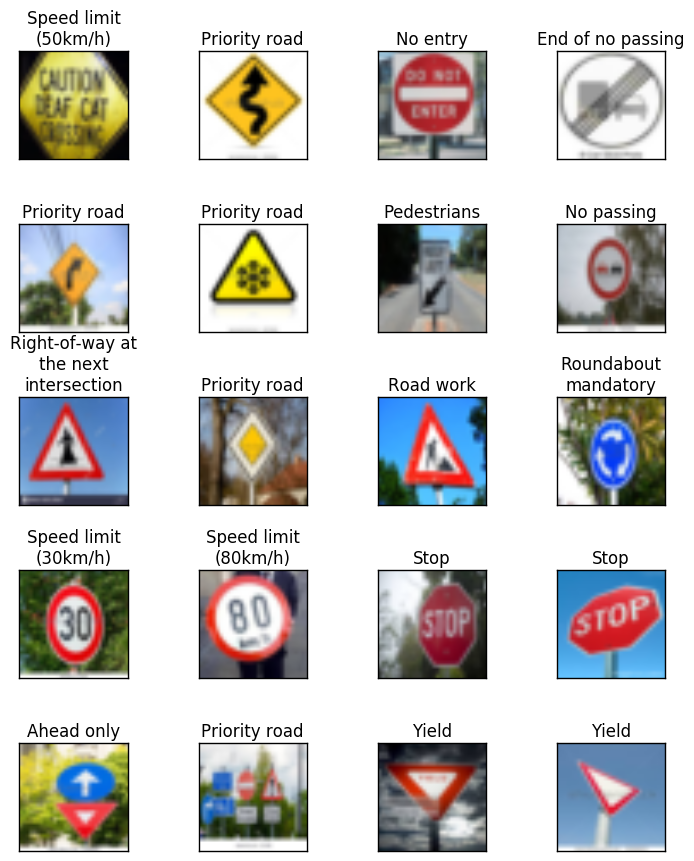

In [21]:
tf.reset_default_graph()

#images
x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]])
#labels
y = tf.placeholder(tf.float32, [None, n_classes])
conv_prob = tf.placeholder(tf.float32)
hidden_prob = tf.placeholder(tf.float32)
logits = convolutional_net(x, n_classes, conv_prob, hidden_prob, show_info=False)

train_dict = {conv_prob: 0.75, hidden_prob: 0.5}
test_dict = {conv_prob: 1.0, hidden_prob: 1.0}
model_directory = "/tmp/traffic_signs"
md = model.Model(x, y,n_classes,train_dict, test_dict, model_directory)
predictions = tf.nn.softmax(logits)

with tf.Session() as sess:
    md.restore_model('trafficSigns/checkpoints/checkpoints_aug/model-50',sess)
    pred = sess.run([predictions], feed_dict={x:images, conv_prob: 1.0, hidden_prob: 1.0}) 
    top_k = tf.nn.top_k(pred[0],3)
    indices = top_k.indices.eval(session=sess)
    probabilities = top_k.values.eval(session=sess)*100
    labels2 = np.argmax(pred[0], axis=1)
    plot_images_with_labels(images, labels2, 5,4)
    

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** The model did not perform equally well on the test images. One reason for this is that it was presented with signs it never saw before. The model seems to assign yellow signs with priority roads and I think this is reasonable. It was able to correctly recognize the US yield sign although it has a thicker border and text on it compared to the German sign. Same can be said about the do not enter sign. 

Also it was able to recognize the Ahead Only sign although the image had yield sign below. It is also interesting that it interpreted the sign with the woman crossing the street (first image on 3rd row) as right of way. This makes a lot of sense becuase this sign is very similar with the right of way sign from the training dataset.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


In [19]:
for index, prob in enumerate(probabilities):
    print("Sign {:d}\n{:.2f}% {:s}\n{:.2f}% {:s}\n{:.2f}% {:s}\n".format(index+1, probabilities[index][0], signNames[str(indices[index][0])],
                                                          probabilities[index][1],signNames[str(indices[index][1])],
                                                          probabilities[index][2],signNames[str(indices[index][2])]))

Sign 1
61.91% Speed limit (50km/h)
38.09% Yield
0.00% Traffic signals

Sign 2
100.00% Priority road
0.00% Yield
0.00% Speed limit (50km/h)

Sign 3
99.02% No entry
0.98% Stop
0.00% Priority road

Sign 4
94.83% End of no passing
3.47% End of speed limit (80km/h)
1.21% End of no passing by vechiles over 3.5 metric tons

Sign 5
100.00% Priority road
0.00% Yield
0.00% No passing for vechiles over 3.5 metric tons

Sign 6
100.00% Priority road
0.00% Yield
0.00% Speed limit (20km/h)

Sign 7
99.66% Pedestrians
0.31% Road work
0.01% End of speed limit (80km/h)

Sign 8
100.00% No passing
0.00% Slippery road
0.00% Dangerous curve to the left

Sign 9
71.20% Right-of-way at the next intersection
28.74% General caution
0.05% Beware of ice/snow

Sign 10
100.00% Priority road
0.00% Speed limit (20km/h)
0.00% Speed limit (30km/h)

Sign 11
100.00% Road work
0.00% Dangerous curve to the right
0.00% Beware of ice/snow

Sign 12
100.00% Roundabout mandatory
0.00% Ahead only
0.00% Keep right

Sign 13
100.00% 

**Answer:** The model is fairly certain of its predictions. It does make some wrong predictions for traffic signs it did not see before and gets less sure when there are multiple signs in the image.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** Images were processed using two transformations
 - resized so they have same image as images in training/testing set
 - normalized like the images in the training/testing set
 
Trained model was loaded from disk and then I apllied softmax to the logits to get probabilibities.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.